In [1]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import pickle
import os
from time import time
import asyncio

from ta.utils import dropna
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator

# Hypothesis

From testing we found that simply using indicators was not enough to find tops and bottom and even mean reversion often did not work due to irrational investors and market risk

Hence, instead of longing at a potential lows, we wanted to test the returns of longing only in the middle of a new uptrend. 

Our strategy is as such:

Long when
1. Adj Close is between  50 day SMA value & (50 day SMA value + 3x ATR) 
        i.  A stronger signal is when Diff between (SMA & Adj Close) is large
2.  AND (MACD line(Fast)– Signal(Slow)) is also positive and large
        i. A stronger signal is when Diff between (MACD line(Fast)– Signal(Slow)) is large

Short when
1. Adj Close is between (50 day SMA value - 0.5x ATR) &  50 day SMA value 
        i.  A stronger signal is when Diff between (SMA & Adj Close) is large
2.  AND (MACD line(Fast)– Signal(Slow))  is also negative and large 
        i. A stronger signal is when Diff between (MACD line(Fast)– Signal(Slow)) is large


In [2]:
def get_signal_per_day(adj_close_val, sma_val,macd_fast_val, macd_slow_val,close_n_sma_distance_short_multiple, close_n_sma_distance_long_multiple,atr_val):
    """
    Function to visualise how signals are calculated for each day
    """
    
    signal_short = -1.0 if (adj_close_val>(sma_val-close_n_sma_distance_short_multiple*atr_val)) & (adj_close_val<sma_val) else 0
    signal_long_n_short = 1.0 if (adj_close_val<(sma_val+close_n_sma_distance_long_multiple*atr_val)) & (adj_close_val>sma_val) else signal_short
    singal_macd = 1.0 if (macd_fast_val>macd_slow_val) else -1.0
    final_signal = (signal_long_n_short+singal_macd)/2.0
    final_signal_clean = final_signal if (final_signal in [1.0,-1,0]) else 0
    signal_strength = ((abs(adj_close_val- sma_val)/adj_close_val + abs(macd_fast_val-macd_slow_val))) * final_signal_clean
    
    return final_signal_clean,signal_strength

In [3]:
get_signal_per_day(adj_close_val= 275.79,sma_val= 267,
                   macd_fast_val= 0.029,macd_slow_val= -1.59,
                   close_n_sma_distance_short_multiple= 0.5,
                   close_n_sma_distance_long_multiple= 3,
                   atr_val = 8.22)

(1.0, 1.6508720765800067)

### Importing Data

In [4]:
class SMACD():  
    
    def __init__(self, stock_list, primary_trend_window, buy_on, verbose,lookback,metrics_calc_start_date,
                  long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,
                  short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple_params,short_rsi_limit,
                     metrics_calc_end_date):

        self.primary_trend_window = primary_trend_window
        self.buy_on= buy_on
        self.verbose = verbose
        self.lookback = lookback
        self.metrics_calc_start_date = metrics_calc_start_date
        self.bt_data = pd.DataFrame()
        self.long_sl_ATR_multiple = long_sl_ATR_multiple,
        self.risk_reward_long = risk_reward_long,
        self.close_n_sma_distance_long_multiple= close_n_sma_distance_long_multiple,
        self.long_rsi_limit = long_rsi_limit,
        self.short_sl_ATR_multiple = short_sl_ATR_multiple,
        self.risk_reward_short = risk_reward_short,
        self.close_n_sma_distance_short_multiple_params = close_n_sma_distance_short_multiple_params,
        self.short_rsi_limit = short_rsi_limit
        self.stock_list = stock_list
        self.metrics_calc_end_date= metrics_calc_end_date


    def get_signals_single_stock(self,stock_symbol):
        """
        Vectorised Function to get the signals for each day 
        """
        if stock_symbol in stock_data_dict:
            stock_data = stock_data_dict[stock_symbol]
        else:
            stock_data =pdr.get_data_yahoo(stock_symbol, start, end)
        SMA = SMAIndicator(close = stock_data['Adj Close'], window = primary_trend_window)
        ATR = AverageTrueRange(high = stock_data['High'],
                           low = stock_data['Low'],
                           close = stock_data['Adj Close'])
        RSI = RSIIndicator(close =  stock_data['Adj Close'])

        MACD_ = MACD(close = stock_data['Adj Close'])  

        stock_data['SMA'] = SMA.sma_indicator()
        stock_data['ATR'] = ATR.average_true_range()
        stock_data['MACD Fast'] = MACD_.macd()
        stock_data['MACD Slow'] = MACD_.macd_signal()
        stock_data['RSI'] = RSI.rsi()

        stock_data['Stop Loss'] = stock_data[buy_on] - long_sl_ATR_multiple*stock_data['ATR'] # 2
        stock_data['Take Profit'] = stock_data[buy_on] +risk_reward_long*(long_sl_ATR_multiple*stock_data['ATR']) # 1

        stock_data['Stop Loss Short'] = stock_data[buy_on] + short_sl_ATR_multiple*stock_data['ATR'] # 1
        stock_data['Take Profit Short'] = stock_data[buy_on] -risk_reward_short*(short_sl_ATR_multiple*stock_data['ATR']) # 0.5

        stock_data = stock_data.copy()
        stock_data.dropna(inplace = True)

        # # Signal Logic
        stock_data['signal_1'] = np.where( 
                            (stock_data['Adj Close'] > (stock_data['SMA'] - close_n_sma_distance_short_multiple*stock_data['ATR']) ) & (stock_data['Adj Close'] < stock_data['SMA']),
                            -1.0,   0) # When it is between the close and abit below it, we short, 0,5

        stock_data['signal_1'] = np.where( 
                            (stock_data['Adj Close'] < (stock_data['SMA'] + close_n_sma_distance_long_multiple*stock_data['ATR']) ) & (stock_data['Adj Close'] > stock_data['SMA']) ,
                            1.0,  stock_data['signal_1']) # When it is between the close and abit above it, we long, 2

        stock_data['signal_2'] = np.where(stock_data['MACD Fast'] >  stock_data['MACD Slow'],1.0,-1.0)
        stock_data['Signal'] = ( stock_data['signal_1']+ stock_data['signal_2'] )/2.0
        stock_data['Signal Clean'] = stock_data['Signal'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
        stock_data['Strength of Signal'] = ((abs(stock_data['Adj Close'] - stock_data['SMA'])/stock_data['Adj Close'] + abs(stock_data['MACD Fast'] -  stock_data['MACD Slow']))) * stock_data['Signal Clean']
        stock_data['Stock_Returns'] = np.log(stock_data[buy_on]/stock_data[buy_on].shift(1)) 
        stock_data['Stock_Returns'] = stock_data['Stock_Returns'].shift(-1) # Changed to tmr/today instead of today/yesterday
        return stock_data
    
    def get_signal_for_mutiple_stocks(self):
        """
        Function that combines data and signals for multiple stocks 
        """

        stock_list_abbr_list = []
        stock_list = self.stock_list
        # Intialise df with first stock in list 
        first_stock = stock_list[0]
        signals_df = self.get_signals_single_stock(first_stock).add_suffix('_'+first_stock) 
        stock_list_abbr_list.append("Strength of Signal_" +first_stock)
        for stock in stock_list[1:]:
            stock_df = self.get_signals_single_stock(stock)
            signals_df= signals_df.merge(stock_df.add_suffix('_'+stock), how='right', left_index=True, right_index=True )
            stock_list_abbr_list.append("Strength of Signal_" +stock)

        signals_df['Chosen'] = signals_df[stock_list_abbr_list].abs().idxmax(axis=1)
        signals_df['Chosen'] = np.where (signals_df[stock_list_abbr_list].abs().max(axis = 1) == 0.0, 0, signals_df['Chosen'])
        temp_data = signals_df[stock_list_abbr_list].copy()

        # If there are many signals in one day, replace them with the stock with the strongest signal
        for i in range(len(temp_data)):
            if (temp_data[i:i+1].max(axis = 1)[0] != 0.0):
                stock_chosen = temp_data[i:i+1].abs().idxmax(axis=1)[0].split("_")[-1]
                signals_df.loc[signals_df.index[i],stock_list_abbr_list] = [0.0] * len(stock_list_abbr_list)
                signals_df.loc[signals_df.index[i],"Strength of Signal_"+stock_chosen] = signals_df.loc[signals_df.index[i],"Signal Clean_"+stock_chosen]
        self.bt_data = signals_df.copy()

    def get_positions(self):
        """
        Function to set the entry points for the day.
        Once, entered position will stay in that stock untill it hits TP or SL
        After closing the position, based on the next signal a new position is opened.
        """
        latest_action,chosen_stock_for_entry = 0,""
        curr_stop, curr_TP,buy_price,short_price = 0,0,0,0
        self.bt_data[ "Open_Entry"] = 0.0
        self.bt_data[ "Close_Entry"] = ""
        self.bt_data[ "Stock_Returns_"] = 0.0
        self.bt_data[ buy_on+"_"] = 0.0
        buy_rsi = []
        sell_rsi = []
        
        # Loop through each day
        for i in range(len(self.bt_data)):
            curr_date = self.bt_data.index[i]

            # If we have no prev position and a new signal is asking to take a position
            if (self.bt_data['Chosen'].iloc[i] != 0.0) & (latest_action == 0):

                chosen_stock_for_entry = self.bt_data['Chosen'].iloc[i].split('_')[-1]

                # Enter Long on chosen stock
                if (self.bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == 1.0):
                    curr_stop, curr_TP = self.bt_data.iloc[i]["Stop Loss_"+chosen_stock_for_entry],self.bt_data.iloc[i]["Take Profit_"+chosen_stock_for_entry]
                    latest_action = 1.0
                    self.bt_data.loc[curr_date, "Open_Entry"] = "Open Long"
                    buy_price = self.bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
                    buy_rsi.append(self.bt_data.iloc[i+1]["RSI_" + chosen_stock_for_entry])
                    if verbose: print(f"Signal to Open Long on {chosen_stock_for_entry} on {curr_date} at {buy_price}")

                # Enter Short on chosen stock
                elif (self.bt_data["Signal Clean_"+chosen_stock_for_entry].iloc[i]  == -1.0):
                    curr_stop, curr_TP = self.bt_data.iloc[i]["Stop Loss Short_"+chosen_stock_for_entry],self.bt_data.iloc[i]["Take Profit Short_"+chosen_stock_for_entry]
                    latest_action = -1.0  
                    self.bt_data.loc[curr_date, "Open_Entry"] = "Open Short"
                    short_price = self.bt_data.iloc[i+1][buy_on+"_" + chosen_stock_for_entry]
                    sell_rsi.append(self.bt_data.iloc[i+1]["RSI_" + chosen_stock_for_entry])
                    if verbose: print(f"Signal to Open Short on {chosen_stock_for_entry} on {curr_date} at {short_price}")

            # if we are already in a long    
            elif (latest_action == 1.0):
                # Close Long if it hits TP
                if (self.bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_TP ) | (self.bt_data.iloc[i]["RSI_" + chosen_stock_for_entry]>long_rsi_limit): 
                    self.bt_data.loc[curr_date, "Close_Entry"] = "Close Long at TP"
                    if verbose: print(f"Signal to Take Profit on Long with {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {(curr_TP-buy_price)/buy_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0


                # Close Long if it hits SL
                elif (self.bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_stop ): 
                    self.bt_data.loc[curr_date, "Close_Entry"] = "Close Long at SL"
                    if verbose:print(f"Signal to Stop Loss on Long on {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {(curr_stop-buy_price)/buy_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0

            # if we are already in a short
            elif (latest_action == -1.0):

                # Close Short if it hits SL
                if (self.bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  >= curr_stop) : 
                    self.bt_data.loc[curr_date, "Close_Entry"] = "Close Short at SL"
                    if verbose: print(f"Signal to Stop Loss on Short with {chosen_stock_for_entry} on {curr_date} at {curr_stop} with a loss of {-(curr_stop-short_price)/short_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0


                # Close Short if it hits TP
                elif (self.bt_data[buy_on+"_"+chosen_stock_for_entry].iloc[i]  <= curr_TP) | (self.bt_data.iloc[i]["RSI_" + chosen_stock_for_entry]<short_rsi_limit): 
                    self.bt_data.loc[curr_date, "Close_Entry"] = "Close Short at TP"
                    if verbose: print(f"Signal to Take Profit on Short on {chosen_stock_for_entry} on {curr_date} at {curr_TP} with a profit of {-(curr_TP-short_price)/short_price}")
                    latest_action,curr_stop, curr_TP = 0,0, 0

            self.bt_data.loc[curr_date, "Position"] = latest_action
            self.bt_data.loc[curr_date, "Invested Stock Returns"] = self.bt_data.loc[curr_date, "Stock_Returns_" + chosen_stock_for_entry]
            self.bt_data.loc[curr_date, "Invested Stock Price"] = self.bt_data.loc[curr_date, buy_on+"_" + chosen_stock_for_entry]
            self.bt_data.loc[curr_date, "Invested in"] = chosen_stock_for_entry

    def riding_the_trend_with_macd(self,show_res= True):
        
        benchmark_data = stock_data_dict[benchmark_stock_symbol]
        # benchmark_data = pdr.get_data_yahoo(benchmark_stock_symbol, start, end)
        
        # Getting position for each day based on the strongest signal
        self.get_positions()

        # Printing the distribution of positions
        if show_res: print("\nDistribution of Positions,\n",self.bt_data.Position.value_counts())
        assert self.bt_data.Position.isin([-1.0,0,1.0]).all(), "Position values are out of range:\n"  + self.bt_data.Position.value_counts().to_string()

        # Printing the number of entires and exits 
        number_trades = self.bt_data[self.bt_data.Open_Entry != 0.0].Open_Entry.count() + self.bt_data[self.bt_data.Close_Entry != ""].Close_Entry.count()
        no_trades = self.bt_data[self.bt_data.Position == 0.0].Position.count() 
        if show_res: print("\nDistribution of exits in percentages\n",self.bt_data[self.bt_data.Close_Entry != ""].Close_Entry.value_counts(normalize=True))
        if show_res: print(f'\nNumber of Entries and Exits are {number_trades} and No trade are {no_trades} \n' )

        # Assuming, we get a signal on open and we are able to buy on the same day open as well
        self.bt_data['Benchmark_Returns'] = np.log(benchmark_data[buy_on]/benchmark_data[buy_on].shift(1))
        self.bt_data['Benchmark_Returns'] = self.bt_data['Benchmark_Returns'].shift(-1)
        self.bt_data['Strategy_Returns'] = self.bt_data['Position'].shift(1) * self.bt_data['Invested Stock Returns'] # since you enter next day
        self.bt_data["Invested in"] = self.bt_data.apply(lambda row: row["Invested in"] if (row["Strategy_Returns"]!=0.0) else "", axis = 1)

        # Plotting entry points and returns 
        stock_list = self.stock_list
        if show_res: 
            for stock in stock_list:
                figure, axis = plt.subplots(2,figsize=(12, 6))
                self.entry_price_plot(self.bt_data.iloc[-lookback:], axis[0],stock )
                self.returns_plot_normal(axis[1],stock)

        # Metrics
        returns_df = pd.DataFrame()
        stock_list_abbr_list = []
        for stock in self.stock_list:
            stock_list_abbr_list.append("Stock_Returns_" +stock)
        stock_list_abbr_list.extend(["Benchmark_Returns","Strategy_Returns"])

        returns_df["Normal"] = self.bt_data[self.metrics_calc_start_date:self.metrics_calc_end_date][stock_list_abbr_list].sum().apply(np.exp)
        returns_df["Log"] = self.bt_data[self.metrics_calc_start_date:self.metrics_calc_end_date][stock_list_abbr_list].sum()

        metrics_df = pd.DataFrame()
        metrics_df["Annual Mean Returns"] = np.exp(self.bt_data[self.metrics_calc_start_date:self.metrics_calc_end_date][stock_list_abbr_list].mean() * 252) -1

        # Annual Standard deviation
        metrics_df["Annual Regular std"] = (np.exp(self.bt_data[self.metrics_calc_start_date:self.metrics_calc_end_date][stock_list_abbr_list])-1).std() * (252 **0.5)  # Note that these are the log returns

        # Annual Standard deviation of Neg Returns
        neg_ret_std = []
        tracking_err = []
        information_ratio = []
        for stock in stock_list_abbr_list:
            neg_ret_std.append((np.exp(self.bt_data[self.bt_data[stock] <0][self.metrics_calc_start_date:self.metrics_calc_end_date][stock])-1).std() * (252 **0.5) )
            if stock != "Benchmark_Returns":
                rf_rm_diff = self.bt_data[self.metrics_calc_start_date:self.metrics_calc_end_date][stock] - self.bt_data[self.metrics_calc_start_date:self.metrics_calc_end_date]["Benchmark_Returns"]
                avg_of_diff_daily = rf_rm_diff.mean()
                sd_of_diff_daily = rf_rm_diff.std()
                IRR_daily = avg_of_diff_daily/sd_of_diff_daily
                tracking_err.append(sd_of_diff_daily*(252**0.5))
                information_ratio.append(IRR_daily *(252**0.5) )
            else:
                tracking_err.append(np.nan)
                information_ratio.append(np.nan )
        metrics_df["Annual Negative Regular std"] = neg_ret_std

        # Sharpe Ratio
        metrics_df["Annual Sharpe Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Annual Regular std'] 

        # Max Drawdown
        metrics_df["Max Drawdown"] =list(map(lambda x: self.drawdown( 0, x, False),stock_list_abbr_list))

        # Calamar Ratio
        metrics_df["Annual Calamar Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Max Drawdown'] 

        # Shortino Ratio
        metrics_df["Annual Shortino Ratio"] = metrics_df['Annual Mean Returns'] /   metrics_df['Annual Negative Regular std'] 

        # Tracking Error
        metrics_df["Annual Tracking Error"] = tracking_err

        # Information Ratio
        metrics_df["Annual Information Ratio"] =information_ratio

        return self.bt_data, returns_df,metrics_df

    def entry_price_plot(self,df,plt,stock_symbol):
        """
        Function to plot the entry points and exits for each stock
        """
        plt.grid(True, alpha = .3)
        stock_price_df = df[buy_on+"_" + stock_symbol]

        # Plotting the Closing prices and SMA for the chosen stock
        plt.plot(stock_price_df, label = f'Daily {buy_on} of {stock_symbol}')
        plt.plot(df['SMA'+"_" + stock_symbol], label = 'SMA')

        # Entry Points
        open_long = (df.Open_Entry == "Open Long") & (df.Chosen == "Strength of Signal_"+stock_symbol)
        open_short = (df.Open_Entry == "Open Short") & (df.Chosen == "Strength of Signal_"+stock_symbol)

        # Exit points
        close_short_tp = (df.Close_Entry == "Close Short at TP") & (df["Invested in"] == stock_symbol)
        close_long_tp = (df.Close_Entry == "Close Long at TP") & (df["Invested in"] == stock_symbol)
        close_short_sl = (df.Close_Entry == "Close Short at SL") & (df["Invested in"] == stock_symbol)
        close_long_sl = (df.Close_Entry == "Close Long at SL") & (df["Invested in"] == stock_symbol)

        plt.plot(df.loc[open_long].index, stock_price_df[open_long], '^',
                 color = 'g', markersize = 12,alpha=0.6, label="Open Long")

        plt.plot(df.loc[open_short].index, stock_price_df[open_short], 'v',
                 color = 'r', markersize = 12,alpha=0.6, label="Open Short")

        plt.plot(df.loc[close_long_tp].index, stock_price_df[close_long_tp], '*',
                 color = 'g', markersize = 12,alpha=0.8, label="TP Long")

        plt.plot(df.loc[close_short_tp].index, stock_price_df[close_short_tp], '*',
                 color = 'r', markersize = 12,alpha=0.8, label="TP Short")

        plt.plot(df.loc[close_long_sl].index, stock_price_df[close_long_sl], 'x',
                 color = 'g', markersize = 12,alpha=0.8, label="SL Long", mew=4)

        plt.plot(df.loc[close_short_sl].index, stock_price_df[close_short_sl], 'x',
                 color = 'r', markersize = 12,alpha=0.8, label="SL Short", mew=4)

        plt.legend(loc=(1.04, 0));


    def returns_plot_log(self,plt,stock_symbol):
        """
        Function to plot the log returns of stock and strategy 
        """
        plt.plot(self.bt_data['Stock_Returns'+"_" + stock_symbol].cumsum(), label=f'Buy/Hold (Log Returns) of {stock_symbol}')
        plt.plot(self.bt_data['Strategy_Returns'].cumsum(), label=f'Strategy (Log Returns)')
        plt.legend(loc=(1.04, 0))
        plt.grid(True, alpha=.3)
        
    def returns_plot_normal(self,plt,stock_symbol):
        """
        Function to plot the normal returns of stock and strategy 
        """
        plt.plot(self.bt_data['Stock_Returns'+"_" + stock_symbol].cumsum().apply(np.exp), label=f'Buy/Hold (Normal Returns) of {stock_symbol}')
        plt.plot(self.bt_data['Strategy_Returns'].cumsum().apply(np.exp), label=f'Strategy (Normal Returns)')
        plt.legend(loc=(1.04, 0))
        plt.grid(True, alpha=.3)


    def drawdown(self,plt, col,plt_bool= True):
        """
        Function to plot the drawdown of column of returns 
        """
        self.bt_data["Gross_Cum_Returns"] = self.bt_data[col].cumsum().apply(np.exp) 
        self.bt_data["Cum_Max"] = self.bt_data["Gross_Cum_Returns"].cummax()

        if plt_bool:
            plt.plot(self.bt_data["Gross_Cum_Returns"],label=f'Gross Cum Returns of {col}')
            plt.plot(self.bt_data["Cum_Max"],label=f'Cum Max of {col}')
            plt.legend(loc=(1.04, 0))

        drawdown = self.bt_data["Cum_Max"] - self.bt_data["Gross_Cum_Returns"] # it gives the difference between orange and blue

        self.bt_data["drawdown"] = drawdown

        # The maximum difference is refered as "Drawdown"
        if plt_bool: print(f"Max Drawdown for {col} is {self.bt_data.drawdown.max()}")
        ## Try to keep to less than 15%
        
        # Added the edgecase when the latest drawdown has not reached new cum max 
        zero_periods = drawdown[(drawdown == 0) | (drawdown.index==drawdown.index[-2])]

        # Taking the difference from the previous period
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]

        if plt_bool: print(f'Max days for drawdown for {col} is {delta_values.max()}')

        return self.bt_data.drawdown.max()

In [5]:
start = "2015-01-01"
end = "2019-12-31"

stock_data_dict = {
    "META" : pdr.get_data_yahoo("META", start, end),
    "AMZN" : pdr.get_data_yahoo("AMZN", start, end),
    "AAPL" : pdr.get_data_yahoo("AAPL", start, end),
    "NFLX" : pdr.get_data_yahoo("NFLX", start, end),
    "GOOG" : pdr.get_data_yahoo("GOOG", start, end),
    "^GSPC" : pdr.get_data_yahoo("^GSPC", start, end) ,
}

In [6]:
# metrics_calc_start_date = "2015-01-01"

primary_trend_window = 50 # 50 
lookback = 652
buy_on = "Open"
verbose = False

# Long Parameters
long_sl_ATR_multiple = 2 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 2.5 # Used to determine how close to SMA can be bought
long_rsi_limit = 80

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 1   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5 # Used to determine how close to SMA can be bought
short_rsi_limit = 20


MAANG_list = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
benchmark_stock_symbol = "^GSPC"

In [7]:
smacd_base = SMACD(MAANG_list, primary_trend_window, buy_on, verbose, lookback, "2015-01-01",
                  long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,
                  short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit,
                  end)
smacd_base.get_signal_for_mutiple_stocks()


Distribution of Positions,
  1.0    968
-1.0    132
 0.0    110
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Long at TP     0.541667
Close Long at SL     0.229167
Close Short at SL    0.125000
Close Short at TP    0.104167
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 97 and No trade are 110 

                      Normal       Log
Stock_Returns_META  2.595420  0.953748
Stock_Returns_AMZN  4.958010  1.601004
Stock_Returns_AAPL  2.330627  0.846137
Stock_Returns_NFLX  5.038560  1.617120
Stock_Returns_GOOG  2.409687  0.879497
Benchmark_Returns   1.557320  0.442966
Strategy_Returns    3.782678  1.330432


,Stock_Returns_META,Stock_Returns_AMZN,Stock_Returns_AAPL,Stock_Returns_NFLX,Stock_Returns_GOOG,Benchmark_Returns,Strategy_Returns
Annual Mean Returns,0.219933,0.396136,0.192875,0.400833,0.201198,0.096727,0.319880
Annual Regular std,0.307841,0.306065,0.264724,0.440837,0.249892,0.124858,0.279062
Annual Negative Regular std,0.238549,0.227662,0.203491,0.312178,0.181086,0.100606,0.211807
Annual Sharpe Ratio,0.714438,1.294285,0.728589,0.909256,0.805141,0.774700,1.146268
Max Drawdown,1.178372,1.862914,0.697749,2.933319,0.538240,0.277851,0.477076
Annual Calamar Ratio,0.186642,0.212643,0.276424,0.136648,0.373808,0.348126,0.670501
Annual Shortino Ratio,0.921964,1.740017,0.947827,1.283988,1.111066,0.961449,1.510241
Annual Tracking Error,0.275754,0.255452,0.225545,0.400811,0.200848,NaN,0.264965
Annual Information Ratio,0.386090,0.944905,0.372589,0.610604,0.453024,NaN,0.695190


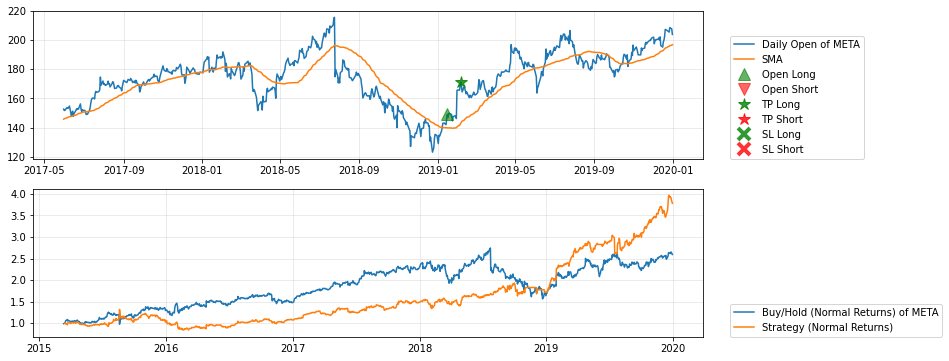

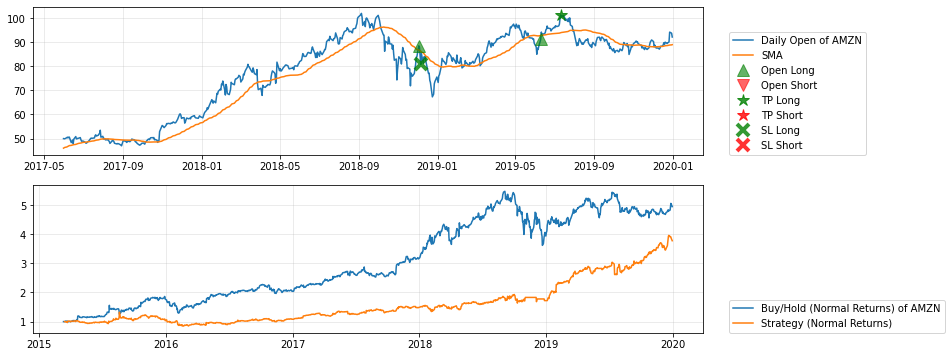

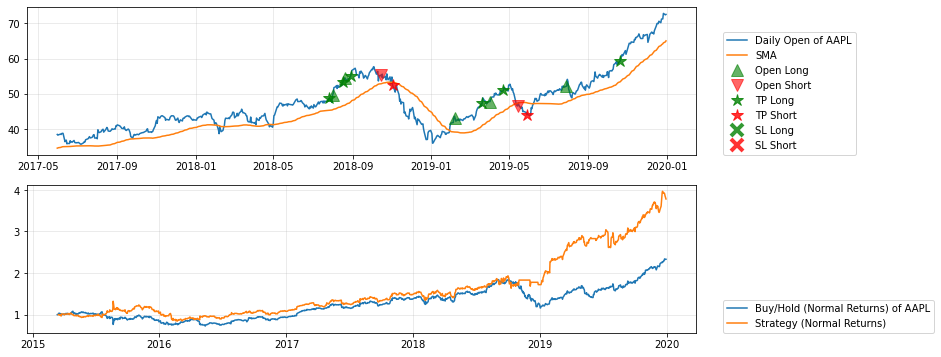

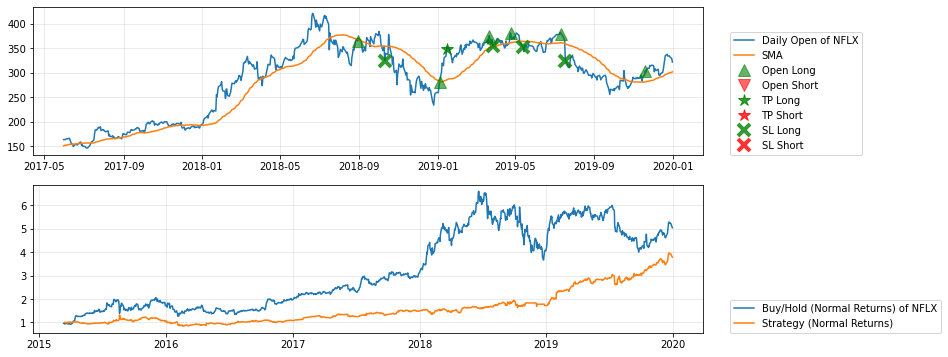

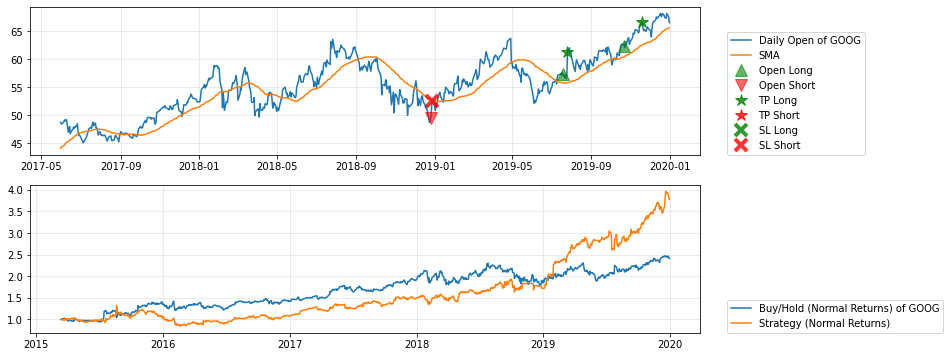

In [8]:
bt_data_base, returns_df_base,metrics_df_base= smacd_base.riding_the_trend_with_macd()
print(returns_df_base)
metrics_df_base.T

# Grid Search

In [9]:
train_history = {}

primary_trend_window_params =                [50,100]
long_sl_ATR_multiple_params =                [1.5, 2]   # Used for long SL
risk_reward_long_params =                    [1.5, 2, 3]     # Used for long TP
close_n_sma_distance_long_multiple_params =  [2.5, 3]   # Used to determine how close to SMA can be bought
long_rsi_limit_params =                      [70,80]

# Short Params
short_sl_ATR_multiple_params=                [1, 1.5]   # Used for Short SL
risk_reward_short_params=                    [0.7, 1, 1.5, 2]   # Used for Short TP
close_n_sma_distance_short_multiple_params = [0.5, 1]   # Used to determine how close to SMA can be bought
short_rsi_limit_params =                     [20, 30]

all_list = [primary_trend_window_params,long_sl_ATR_multiple_params,risk_reward_long_params,
            close_n_sma_distance_long_multiple_params,long_rsi_limit_params,short_sl_ATR_multiple_params,
           risk_reward_short_params,close_n_sma_distance_short_multiple_params,short_rsi_limit_params]

parameters = list(itertools.product(*all_list))

print(f"{len(parameters)} Available combinations" )

1536 Available combinations


In [10]:
cwd = os.getcwd() 
path = os.path.join(cwd +"\\Tuning" )
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [11]:
load = True
if load:
    all_metrics_df = load_file('Tuning/All_Metrics.pkl')
    all_returns_df = load_file('Tuning/All_Returns.pkl')
    train_history = load_file('Tuning/train_history.pkl')

In [12]:
for iteration in tqdm(range(len(parameters))):
    if parameters[iteration] in train_history:
        continue
    else:
        primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= parameters[iteration] # 50 

        smacd_tuning = SMACD(MAANG_list,primary_trend_window, buy_on, verbose, lookback, '2015-01-01',
                      long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,
                      short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit)
        smacd_tuning.get_signal_for_mutiple_stocks()
        _, returns_df,metrics_df= smacd_tuning.riding_the_trend_with_macd(show_res=False)
        if iteration== 0:
            all_returns_df = returns_df
            all_metrics_df = metrics_df
            all_returns_df= all_returns_df.rename(index={"Strategy_Returns": f"Combination of param {iteration}"})
            all_metrics_df = all_metrics_df.rename(index={"Strategy_Returns": f"Combination of param {iteration}"})
        else:
            all_returns_df.loc[f"Combination of param {iteration}"] = returns_df.loc['Strategy_Returns']
            all_metrics_df.loc[f"Combination of param {iteration}"] = metrics_df.loc['Strategy_Returns']
        train_history[parameters[iteration]] = True

save_file('Tuning/All_Metrics.pkl',all_metrics_df )
save_file('Tuning/All_Returns.pkl',all_returns_df )
save_file('Tuning/train_history.pkl',train_history )

100%|█████████████████████████████████████████████████████████████████████████| 1536/1536 [00:00<00:00, 1540519.12it/s]


In [13]:
all_metrics_df['Params'] = [np.nan]*6 + parameters

In [14]:
top_ten_params = all_metrics_df.sort_values(['Annual Information Ratio','Annual Calamar Ratio'], ascending =[False, True]).head(10)
top_ten_params

,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio,Params
Combination of param 1155,0.563877,0.272338,0.188080,2.070506,0.631599,0.892777,2.998068,0.279958,1.268071,"(100, 2, 1.5, 2.5, 70, 1, 0.7, 1, 30)"
Combination of param 1371,0.561964,0.279649,0.192814,2.009536,0.704905,0.797220,2.914541,0.280123,1.262953,"(100, 2, 2, 3, 70, 1.5, 1.5, 1, 30)"
Combination of param 1179,0.560393,0.277230,0.191811,2.021402,1.047374,0.535046,2.921588,0.281064,1.255146,"(100, 2, 1.5, 2.5, 70, 1.5, 1.5, 1, 30)"
Combination of param 1367,0.545358,0.277383,0.193155,1.966081,0.724031,0.753225,2.823428,0.276399,1.241302,"(100, 2, 2, 3, 70, 1.5, 1, 1, 30)"
Combination of param 417,0.537179,0.281579,0.195266,1.907737,0.879921,0.610486,2.751014,0.271784,1.238521,"(50, 2, 1.5, 2.5, 80, 1, 0.7, 0.5, 30)"
Combination of param 931,0.535125,0.263723,0.184421,2.029121,0.631599,0.847255,2.901652,0.272222,1.235938,"(100, 1.5, 2, 2.5, 80, 1, 0.7, 1, 30)"
Combination of param 481,0.531699,0.279124,0.192274,1.904882,0.921013,0.577297,2.765321,0.271593,1.226240,"(50, 2, 1.5, 3, 80, 1, 0.7, 0.5, 30)"
Combination of param 485,0.536921,0.282141,0.191582,1.903022,0.936164,0.573533,2.802571,0.274813,1.224256,"(50, 2, 1.5, 3, 80, 1, 1, 0.5, 30)"
Combination of param 1175,0.538723,0.274765,0.192337,1.960666,1.072311,0.502395,2.800940,0.277212,1.222137,"(100, 2, 1.5, 2.5, 70, 1.5, 1, 1, 30)"
Combination of param 493,0.549030,0.288062,0.193995,1.905946,0.972052,0.564815,2.830115,0.282513,1.218668,"(50, 2, 1.5, 3, 80, 1, 2, 0.5, 30)"


While 1155 may have the best performance for the entire 5 years, we need to perform additional testing per year to confirm this

In [15]:
all_returns_df.sort_values('Normal',ascending=False).head(10)

,Normal,Log
Combination of param 493,8.148542,2.097839
Combination of param 429,7.950780,2.073270
Combination of param 417,7.854022,2.061026
Combination of param 485,7.847697,2.060220
Combination of param 1155,7.805610,2.054843
Combination of param 1371,7.761841,2.049220
Combination of param 1179,7.726027,2.044595
Combination of param 481,7.720691,2.043904
Combination of param 1163,7.696112,2.040715
Combination of param 1167,7.601250,2.028313


Based on raw returns 493 seems like a good candidate as well

# Choosing Best Model

## In Sample Testing

Testing the paramters on a year by year basis

In [29]:
from dateutil.relativedelta import relativedelta
from datetime import datetime
all_returns_df_in_sample = pd.DataFrame(columns=['Normal','Log'])
all_metrics_df_in_sample = pd.DataFrame(columns=['Annual Mean Returns', 'Annual Regular std',
       'Annual Negative Regular std', 'Annual Sharpe Ratio', 'Max Drawdown',
       'Annual Calamar Ratio', 'Annual Shortino Ratio',
       'Annual Tracking Error', 'Annual Information Ratio'] )
if (load==False):
    for param_no,param in tqdm(enumerate(top_ten_params['Params'])):
        primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= param 
        for i in range(4):
            metrics_start_date = str(datetime.strptime('2015-01-01','%Y-%m-%d').date() + relativedelta(years=i))
            metrics_end_date = str(datetime.strptime('2015-01-01','%Y-%m-%d').date() + relativedelta(years=i+1))
            smacd_tuning = SMACD(MAANG_list,primary_trend_window, buy_on, verbose, lookback, metrics_start_date,
                      long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,
                      short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit,
                                metrics_calc_end_date=metrics_end_date)
            smacd_tuning.get_signal_for_mutiple_stocks()
            _, returns_df,metrics_df= smacd_tuning.riding_the_trend_with_macd(show_res=False)

            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}"] = returns_df.loc['Strategy_Returns']
            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}","Iteration"] = i
            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}","Param"] = top_ten_params.index[param_no]
            all_returns_df_in_sample.loc[f"Iteration {i} of param {param_no}","Period"] = metrics_start_date + "---" + metrics_end_date

            all_metrics_df_in_sample.loc[f"Iteration {i} of param {param_no}"] = metrics_df.loc['Strategy_Returns']
            all_metrics_df_in_sample.loc[f"Iteration {i} of param {param_no}","Iteration"] = i
            all_metrics_df_in_sample.loc[f"Iteration {i} of param {param_no}","Param"] = top_ten_params.index[param_no]
            all_metrics_df_in_sample.loc[f"Iteration {i} of param {param_no}","Period"] = metrics_start_date + "---" + metrics_end_date    
    save_file('Tuning/all_returns_df_in_sample.pkl',all_returns_df_in_sample )
    save_file('Tuning/all_metrics_df_in_sample.pkl',all_metrics_df_in_sample )

all_returns_df_in_sample = load_file('Tuning/all_returns_df_in_sample.pkl')
all_metrics_df_in_sample = load_file('Tuning/all_metrics_df_in_sample.pkl')

In [30]:
all_metrics_df_in_sample.head(8)

,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio,Iteration,Param,Period
Iteration 0 of param 0,2.073972,0.381421,0.197519,5.437489,0.631599,3.283686,10.500098,0.422638,2.782966,0.0,Combination of param 1155,2015-01-01---2016-01-01
Iteration 1 of param 0,0.172805,0.309106,0.235732,0.559048,0.631599,0.273599,0.733058,0.310291,0.192844,1.0,Combination of param 1155,2016-01-01---2017-01-01
Iteration 2 of param 0,0.279770,0.163324,0.147335,1.712977,0.631599,0.442955,1.898872,0.151308,0.465283,2.0,Combination of param 1155,2017-01-01---2018-01-01
Iteration 3 of param 0,0.342130,0.267032,0.169471,1.281233,0.631599,0.541689,2.018814,0.276618,1.354770,3.0,Combination of param 1155,2018-01-01---2019-01-01
Iteration 0 of param 1,1.884221,0.387235,0.188393,4.865833,0.704905,2.673015,10.001530,0.429129,2.592395,0.0,Combination of param 1371,2015-01-01---2016-01-01
Iteration 1 of param 1,0.128013,0.254216,0.213142,0.503559,0.704905,0.181603,0.600598,0.261032,0.080054,1.0,Combination of param 1371,2016-01-01---2017-01-01
Iteration 2 of param 1,0.318154,0.164248,0.147335,1.937035,0.704905,0.451343,2.159396,0.151464,0.659910,2.0,Combination of param 1371,2017-01-01---2018-01-01
Iteration 3 of param 1,0.493857,0.339080,0.222912,1.456462,0.704905,0.700600,2.215476,0.329517,1.462310,3.0,Combination of param 1371,2018-01-01---2019-01-01


### Mean Performance per Period 

Seems like the Strategy works especially well for period where the market goes sideways as seen in the performance in 2015 to 2016

In [31]:
all_metrics_df_in_sample.groupby(by  = 'Period').mean(numeric_only= True).sort_values(['Annual Information Ratio','Annual Calamar Ratio'], ascending =[False, True])

,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio,Iteration
Period,,,,,,,,,,
2015-01-01---2016-01-01,1.459955,0.373691,0.184428,3.853029,0.852097,1.854547,7.767305,0.412068,2.169100,0.0
2018-01-01---2019-01-01,0.371396,0.292796,0.207294,1.272683,0.852097,0.461146,1.826363,0.280371,1.411966,3.0
2017-01-01---2018-01-01,0.383423,0.175263,0.141355,2.155525,0.852097,0.457293,2.759047,0.161739,0.865146,2.0
2016-01-01---2017-01-01,0.184816,0.280068,0.210777,0.646348,0.852097,0.207755,0.886330,0.283333,0.218988,1.0


### Mean Performance per Year 

In [32]:
all_returns_df_in_sample.groupby(by  = 'Param').mean(numeric_only= True)

,Normal,Log,Iteration
Param,,,
Combination of param 1155,1.442332,0.344998,1.5
Combination of param 1175,1.464885,0.368386,1.5
Combination of param 1179,1.478674,0.379092,1.5
Combination of param 1367,1.440055,0.347341,1.5
Combination of param 1371,1.459652,0.359620,1.5
Combination of param 417,1.369907,0.312761,1.5
Combination of param 481,1.381392,0.314696,1.5
Combination of param 485,1.397383,0.324442,1.5
Combination of param 493,1.408244,0.330523,1.5


In [33]:
best_of_the_best = all_metrics_df_in_sample.groupby(by  = 'Param').mean(numeric_only= True).sort_values(['Annual Information Ratio','Annual Calamar Ratio'], ascending =[False, True])
best_of_the_best

,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio,Iteration
Param,,,,,,,,,,
Combination of param 1179,0.720315,0.285187,0.190058,2.261809,1.047374,0.687734,3.794371,0.294133,1.280795,1.5
Combination of param 1175,0.706408,0.282534,0.190690,2.219666,1.072311,0.658772,3.723730,0.289812,1.260254,1.5
Combination of param 931,0.722872,0.274028,0.182345,2.311938,0.631599,1.144511,3.966773,0.282923,1.245866,1.5
Combination of param 1155,0.717169,0.280221,0.187514,2.247687,0.631599,1.135483,3.787711,0.290214,1.198966,1.5
Combination of param 1371,0.706061,0.286195,0.192946,2.190722,0.704905,1.001640,3.744250,0.292786,1.198667,1.5
Combination of param 1367,0.686316,0.283941,0.193381,2.147384,0.724031,0.947909,3.653651,0.289117,1.180953,1.5
Combination of param 485,0.441789,0.279796,0.179956,1.641216,0.936164,0.471914,2.734694,0.278649,1.099941,1.5
Combination of param 481,0.425721,0.274413,0.180240,1.620681,0.921013,0.462231,2.586984,0.272565,1.085499,1.5
Combination of param 493,0.461495,0.284995,0.182095,1.665167,0.972052,0.474764,2.745475,0.284858,1.085482,1.5


In [34]:
best_params = parameters[int(best_of_the_best.index[0].split(" ")[-1])]
primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= best_params # 50 
print(f'primary_trend_window = {primary_trend_window},\nlong_sl_ATR_multiple = {long_sl_ATR_multiple},\nrisk_reward_long = {risk_reward_long},\nclose_n_sma_distance_long_multiple = {close_n_sma_distance_long_multiple},\nlong_rsi_limit = {long_rsi_limit},\nshort_sl_ATR_multiple = {short_sl_ATR_multiple},\nrisk_reward_short = {risk_reward_short},\nclose_n_sma_distance_short_multiple = {close_n_sma_distance_short_multiple},\nshort_rsi_limit = {short_rsi_limit},')

primary_trend_window = 100,
long_sl_ATR_multiple = 2,
risk_reward_long = 1.5,
close_n_sma_distance_long_multiple = 2.5,
long_rsi_limit = 70,
short_sl_ATR_multiple = 1.5,
risk_reward_short = 1.5,
close_n_sma_distance_short_multiple = 1,
short_rsi_limit = 30,


In [247]:
smacd_best = SMACD(MAANG_list, primary_trend_window, buy_on, verbose, lookback, '2015-01-01',
                  long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,
                  short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit,
                  end)
smacd_best.get_signal_for_mutiple_stocks()


Distribution of Positions,
  1.0    715
 0.0    226
-1.0    219
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Long at TP     0.620253
Close Short at TP    0.215190
Close Short at SL    0.088608
Close Long at SL     0.075949
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 158 and No trade are 226 

                      Normal       Log
Stock_Returns_META  2.536367  0.930733
Stock_Returns_AMZN  4.321915  1.463699
Stock_Returns_AAPL  2.186501  0.782302
Stock_Returns_NFLX  3.623095  1.287329
Stock_Returns_GOOG  2.471772  0.904935
Benchmark_Returns   1.512784  0.413951
Strategy_Returns    7.726027  2.044595


,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio
Stock_Returns_META,0.224299,0.311462,0.242607,0.720149,1.151560,0.194778,0.924534,0.278691,0.403181
Stock_Returns_AMZN,0.374720,0.305521,0.231574,1.226497,1.623909,0.230752,1.618143,0.253729,0.899562
Stock_Returns_AAPL,0.185418,0.266770,0.206314,0.695045,0.654600,0.283253,0.898713,0.227703,0.351730
Stock_Returns_NFLX,0.323001,0.443452,0.315098,0.728378,2.109272,0.153134,1.025079,0.402557,0.471727
Stock_Returns_GOOG,0.217451,0.252217,0.184282,0.862158,0.552107,0.393856,1.179989,0.202297,0.527710
Benchmark_Returns,0.094180,0.125852,0.102233,0.748338,0.269905,0.348937,0.921224,NaN,NaN
Strategy_Returns,0.560393,0.277230,0.191811,2.021402,1.047374,0.535046,2.921588,0.281064,1.255146


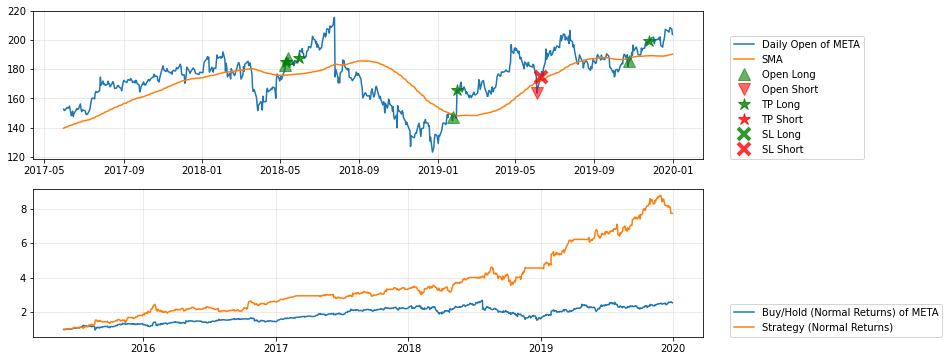

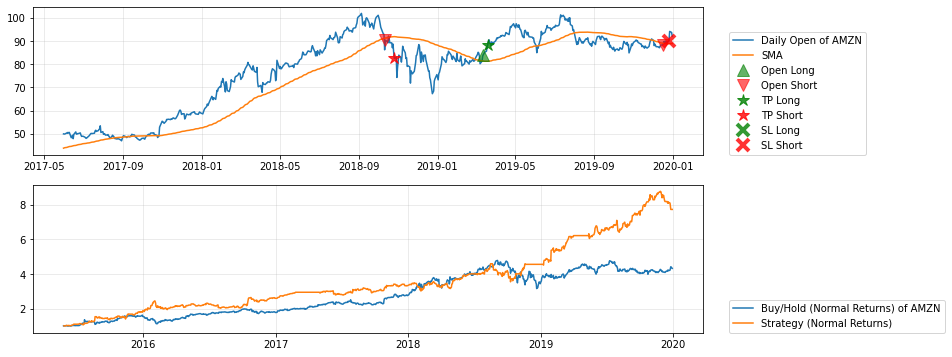

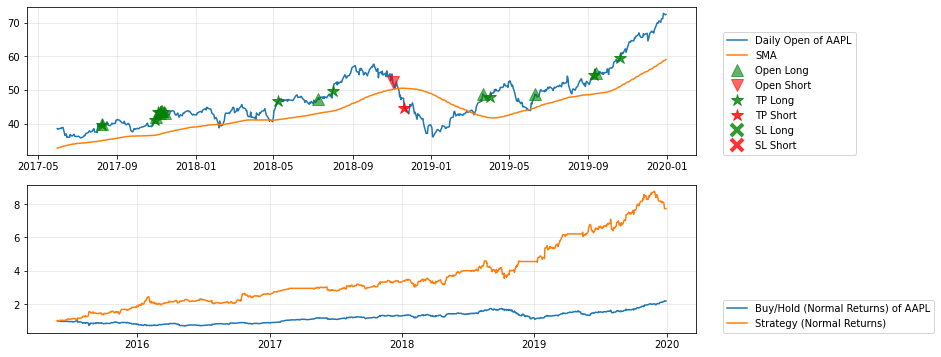

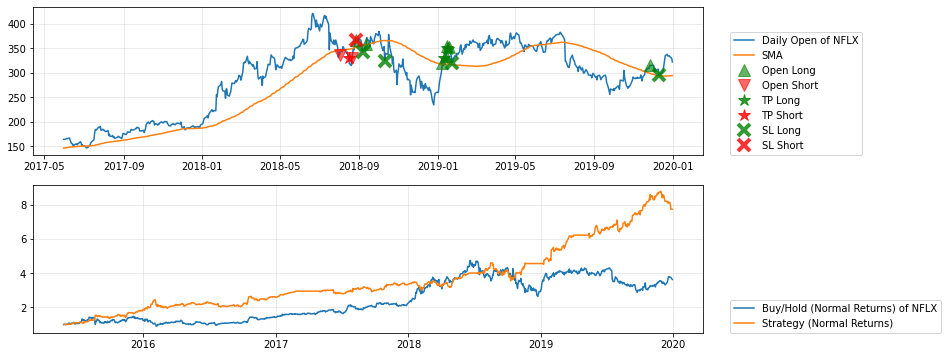

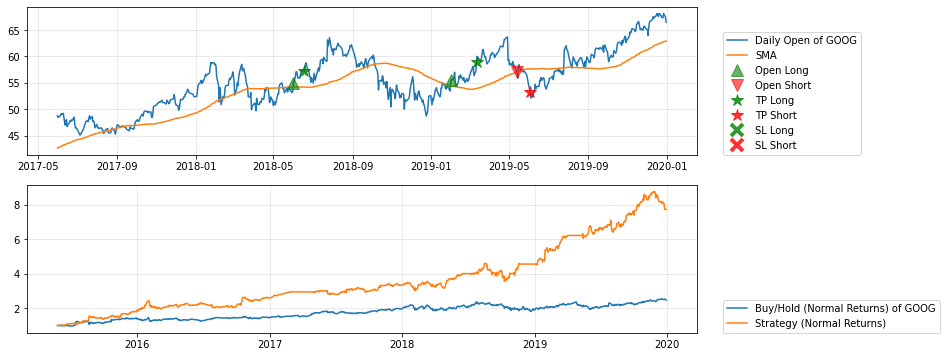

In [248]:
bt_data_best, returns_df_best,metrics_df_best= smacd_best.riding_the_trend_with_macd()
print(returns_df_best)
metrics_df_best

# Data Visualisation

Use any of these below to copy the data back into excel

In [249]:
# signals_df,temp_data = get_signal_for_mutiple_stocks(MAANG_list,start, end,primary_trend_window ,buy_on)

In [250]:
# temp_data.to_clipboard()

In [251]:
# bt_data[(bt_data["Invested Stock Returns"]!= 0.0) |(bt_data["Position"]!= 0.0)][["Chosen","Open_Entry","Close_Entry","Position","Invested Stock Price","Invested Stock Returns","Invested in","Strategy_Returns"]].to_clipboard()

In [252]:
# bt_data[(bt_data["Invested Stock Returns"]!= 0.0) |(bt_data["Position"]!= 0.0)].to_clipboard()

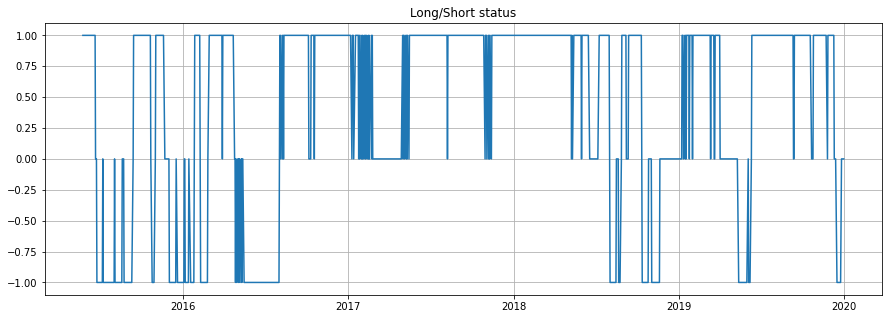

In [253]:
# Lets look from the position view Long or Short
plt.figure(figsize=(15, 5))
plt.plot(bt_data_best["Position"])
plt.title("Long/Short status")
plt.grid()
plt.show()

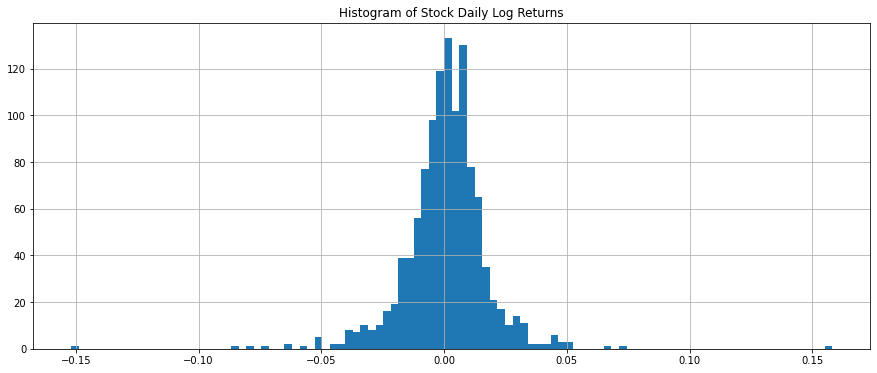

In [254]:
# The histogram of returns
plt.figure(figsize=(15, 6))
plt.hist(bt_data_best["Stock_Returns_AAPL"], bins = 100) 
plt.title("Histogram of Stock Daily Log Returns")
plt.grid()
plt.show()

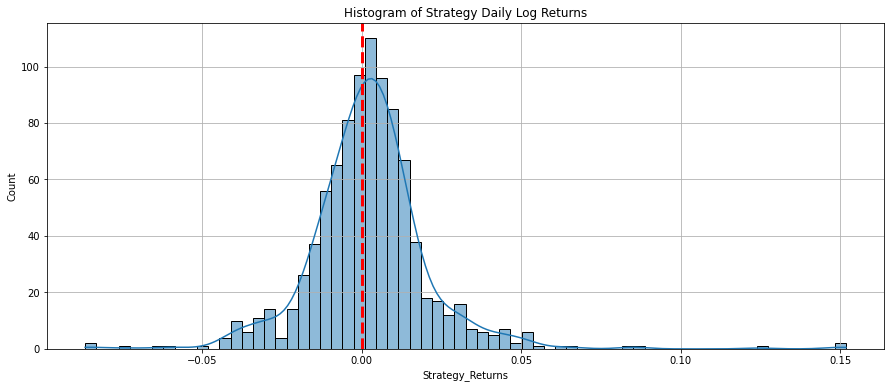

In [255]:
# The histogram of returns
# Going for less wins but big wins, Positive Skew 
# Due to close stop loss which exits out trade early but large take profits allow us to get big wins
plt.figure(figsize=(15, 6))
sns.histplot(bt_data_best[bt_data_best["Strategy_Returns"]!= 0.0]["Strategy_Returns"], kde = True)
plt.axvline(0, color='r', linestyle='dashed', linewidth=3)
plt.title("Histogram of Strategy Daily Log Returns")
plt.grid()
plt.show()

Max Drawdown for Strategy_Returns is 1.0473744979361914
Max days for drawdown for Strategy_Returns is 258 days 00:00:00


Max Drawdown for Stock_Returns_AAPL is 0.654600294542947
Max days for drawdown for Stock_Returns_AAPL is 571 days 00:00:00
Max Drawdown for Stock_Returns_META is 1.1515603928279707
Max days for drawdown for Stock_Returns_META is 524 days 00:00:00
Max Drawdown for Stock_Returns_AMZN is 1.6239089692556994
Max days for drawdown for Stock_Returns_AMZN is 482 days 00:00:00
Max Drawdown for Stock_Returns_GOOG is 0.5521073168221207
Max days for drawdown for Stock_Returns_GOOG is 274 days 00:00:00
Max Drawdown for Stock_Returns_NFLX is 2.10927166701148
Max days for drawdown for Stock_Returns_NFLX is 558 days 00:00:00


2.10927166701148

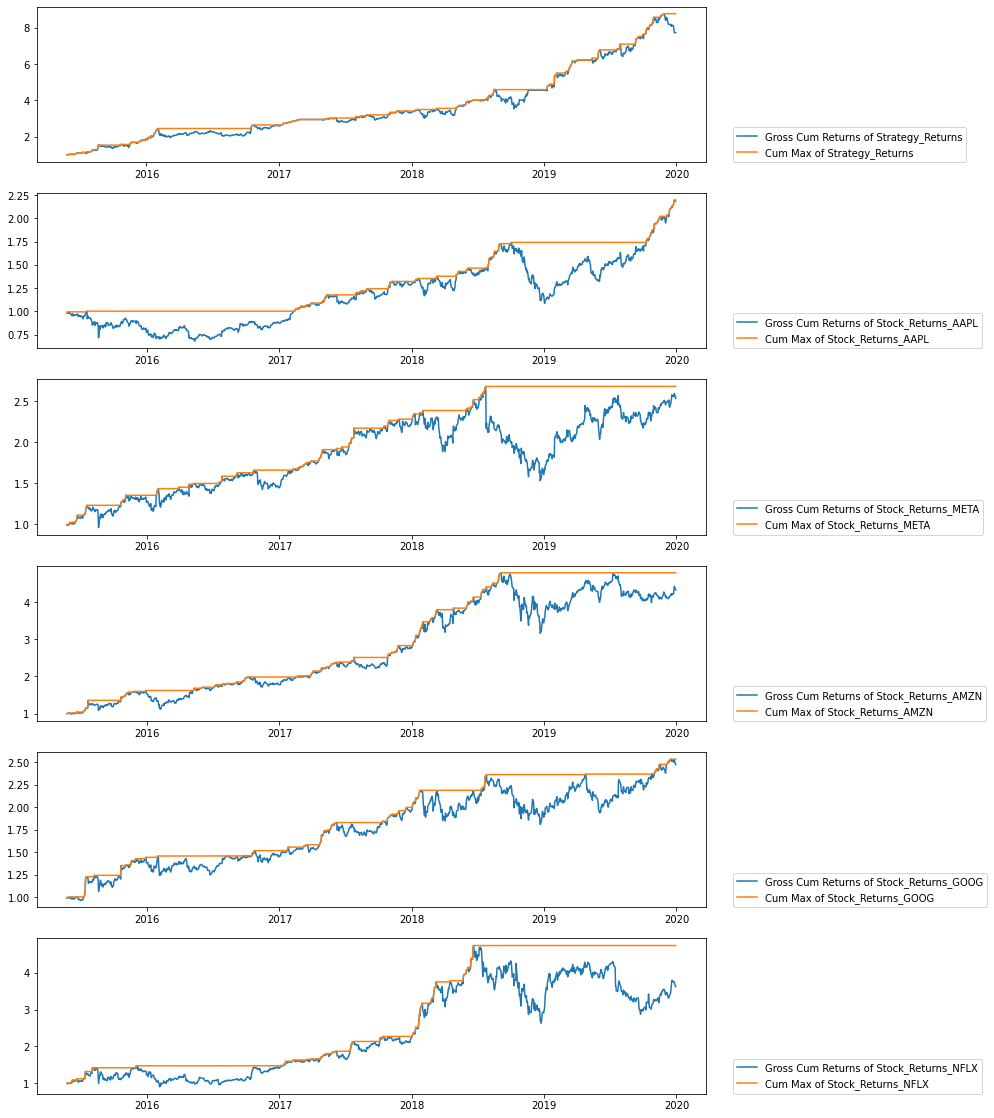

In [256]:
figure, axis = plt.subplots(6, figsize=(12, 20))
# plt, col,plt_bool= True
smacd_best.drawdown(axis[0], "Strategy_Returns" )
print('\n')
smacd_best.drawdown(axis[1], "Stock_Returns_AAPL")
smacd_best.drawdown(axis[2], "Stock_Returns_META")
smacd_best.drawdown(axis[3], "Stock_Returns_AMZN")
smacd_best.drawdown(axis[4], "Stock_Returns_GOOG")
smacd_best.drawdown(axis[5], "Stock_Returns_NFLX")

# Single Stock Demo

In [234]:
primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= best_params # 50 

In [235]:
smacd_single = SMACD(["AMZN"], primary_trend_window, buy_on, verbose, lookback, '2015-01-01',
                  long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,
                  short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit,end)
smacd_single.get_signal_for_mutiple_stocks()


Distribution of Positions,
  0.0    947
-1.0    122
 1.0     91
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Short at SL    0.315789
Close Short at TP    0.263158
Close Long at TP     0.263158
Close Long at SL     0.157895
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 38 and No trade are 947 

                      Normal       Log
Stock_Returns_AMZN  4.321915  1.463699
Benchmark_Returns   1.512784  0.413951
Strategy_Returns    1.233178  0.209595


,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio
Stock_Returns_AMZN,0.374720,0.305521,0.231574,1.226497,1.623909,0.230752,1.618143,0.253729,0.899562
Benchmark_Returns,0.094180,0.125852,0.102233,0.748338,0.269905,0.348937,0.921224,NaN,NaN
Strategy_Returns,0.046668,0.125227,0.163991,0.372665,0.279948,0.166701,0.284573,0.183029,-0.254335


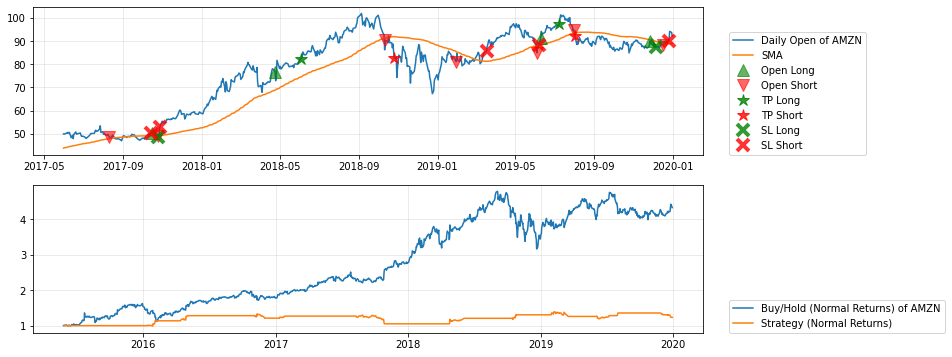

In [236]:
bt_data_single, returns_df_single,metrics_df_single= smacd_single.riding_the_trend_with_macd()
print(returns_df_single)
metrics_df_single

# CRYPTO Demo

In [213]:
start = "2018-01-01"
end = "2022-12-31"

# # Long Parameters
# long_sl_ATR_multiple = 1.5 # Used for long SL
# risk_reward_long = 2    # Used for long TP
# close_n_sma_distance_long_multiple = 3 # Used to determine how close to SMA can be bought
# long_rsi_limit = 80

# # Short Params
# short_sl_ATR_multiple= 1 # Used for Short SL
# risk_reward_short= 0.7   # Used for Short TP
# close_n_sma_distance_short_multiple = 0.5  # Used to determine how close to SMA can be bought
# short_rsi_limit = 20

# Just using param optimised for traditional stocks 
primary_trend_window,long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit= best_params # 50 

CRYPTO_list = ["BTC-USD","ETH-USD","XRP-USD","LTC-USD"]

In [215]:
smacd_crypto = SMACD(CRYPTO_list,primary_trend_window, buy_on, verbose, lookback, '2018-01-01',
                  long_sl_ATR_multiple,risk_reward_long,close_n_sma_distance_long_multiple,long_rsi_limit,
                  short_sl_ATR_multiple,risk_reward_short,close_n_sma_distance_short_multiple,short_rsi_limit,end)
smacd_crypto.get_signal_for_mutiple_stocks()


Distribution of Positions,
  0.0    693
 1.0    530
-1.0    414
Name: Position, dtype: int64

Distribution of exits in percentages
 Close Long at TP     0.402597
Close Long at SL     0.233766
Close Short at TP    0.220779
Close Short at SL    0.142857
Name: Close_Entry, dtype: float64

Number of Entries and Exits are 155 and No trade are 693 

                          Normal       Log
Stock_Returns_BTC-USD   2.757676  1.014388
Stock_Returns_ETH-USD   3.313803  1.198096
Stock_Returns_XRP-USD   0.958010 -0.042897
Stock_Returns_LTC-USD   0.453990 -0.789681
Benchmark_Returns       1.228490  0.205786
Strategy_Returns       40.419193  3.699305


,Annual Mean Returns,Annual Regular std,Annual Negative Regular std,Annual Sharpe Ratio,Max Drawdown,Annual Calamar Ratio,Annual Shortino Ratio,Annual Tracking Error,Annual Information Ratio
Stock_Returns_BTC-USD,0.169119,0.595459,0.444694,0.284014,6.958100,0.024305,0.380304,0.591195,-0.990366
Stock_Returns_ETH-USD,0.202675,0.787512,0.576428,0.257361,9.521277,0.021286,0.351604,0.797795,-1.713449
Stock_Returns_XRP-USD,-0.006586,0.936289,0.614423,-0.007034,3.051167,-0.002158,-0.010719,0.787975,-1.240492
Stock_Returns_LTC-USD,-0.114531,0.818017,0.580386,-0.140011,2.925339,-0.039151,-0.197336,0.774325,-1.922498
Benchmark_Returns,0.126303,0.129441,0.102004,0.975753,0.219182,0.576246,1.238217,NaN,NaN
Strategy_Returns,0.768564,0.573338,0.452948,1.340507,21.449748,0.035831,1.696804,0.575850,-0.002103


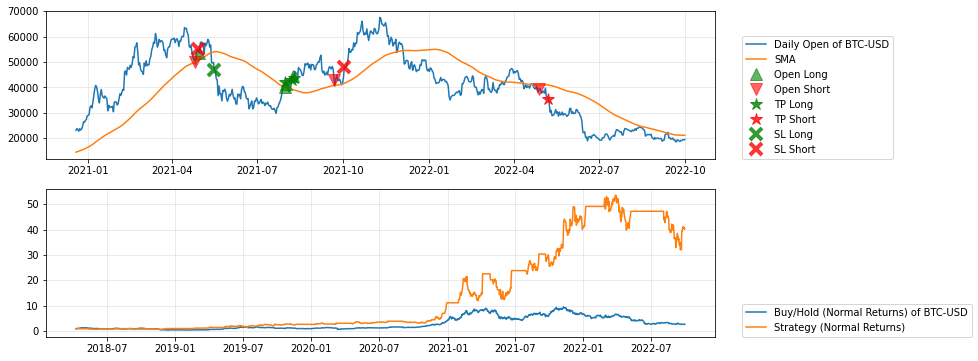

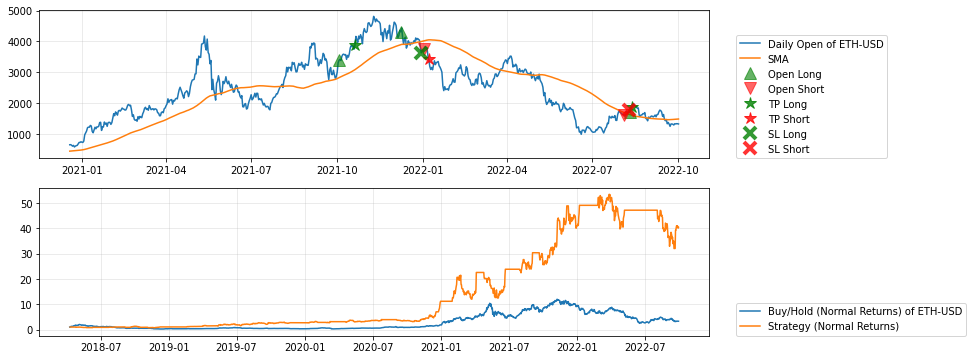

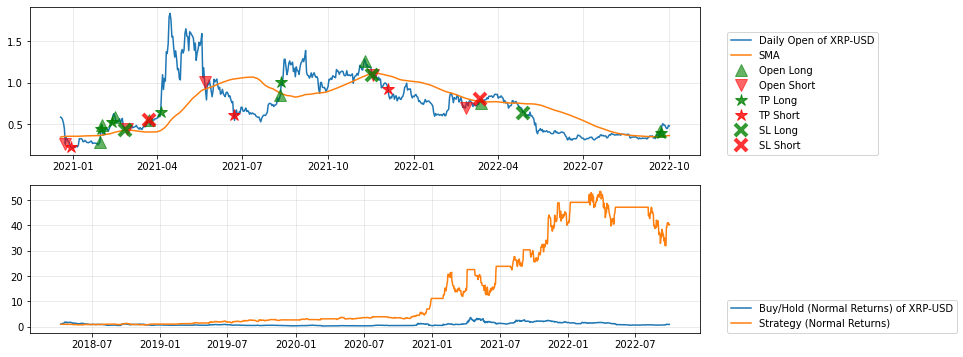

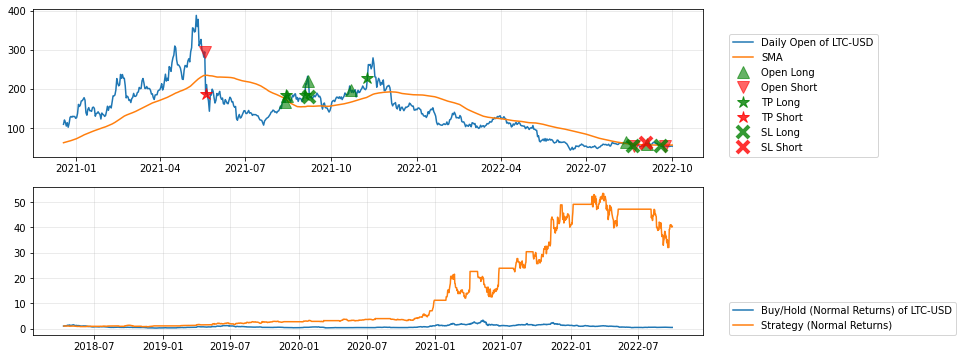

In [216]:
bt_data_crypto, returns_df_crypto,metrics_df_crypto= smacd_crypto.riding_the_trend_with_macd()
print(returns_df_crypto)
metrics_df_crypto

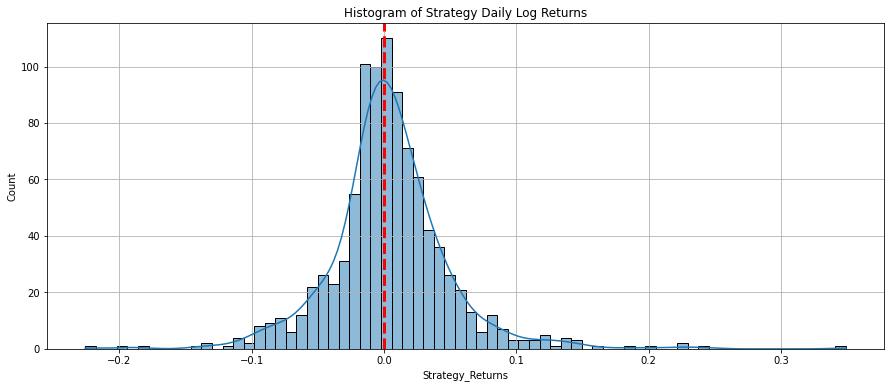

In [217]:
# The histogram of returns
# Going for less wins but big wins, Positive Skew 
# Due to close stop loss which exits out trade early but large take profits allow us to get big wins
plt.figure(figsize=(15, 6))
sns.histplot(bt_data_crypto[bt_data_crypto["Strategy_Returns"]!= 0.0]["Strategy_Returns"], kde = True)
plt.axvline(0, color='r', linestyle='dashed', linewidth=3)
plt.title("Histogram of Strategy Daily Log Returns")
plt.grid()
plt.show()